### VAE as Generative Model

In this part we will draw a comparison between Autoencoders and Variational Autoencoders. We will see how plain AE are good to learn a single latent representation of data but they are not good for generation when we sample from proability distribtion. On the other hand, VAE can map input data to continuous probability distribution. This distribution is normal distribution in case of VAEs. Once we learn this mapping, we can generate new images by simply taking samples from the learnt distribution. 

### Imports

In [ ]:
import os
import random
import numpy as np
from glob import glob
from scipy.stats import norm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape
from keras.layers import Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# just a little hack so that tensorflow can accpet our custom loss function
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

### Loading, Unzipping and Displaying the Dataset

Mounting your google drive.

In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


Unzipping the data file to load it locally in the colab runtime. You can see your unzipped files by clicking the folder icon on left side of your colab.

In [ ]:
# replace this your google drive path of the zip file of dataset provided with this homework
!unzip -o -q "/drive/MyDrive/ffhq-dataset.zip" -d "/content/data"

In [ ]:
DATA_FOLDER = '/content/data/hack'

filenames = np.array(glob(os.path.join(DATA_FOLDER, '*/*.png')))
NUM_IMAGES = len(filenames)
print("Total number of images : " + str(NUM_IMAGES))

Total number of images : 70000


The dataset is quite large (70000 images) which makes it impossible to load it all at the same time in computer memory. We will use Keras' <i>ImageDataGenerator</i> object and call its member function - <i>flow_from_directory</i> to define the flow of data directly from disk rather than loading the entire dataset into memory. You can also apply various transformations (for augmentation) to the images directly while loading the data (e.g normalizing, rescaling, rotating etc).


You can read more about this in official Keras [documentation](https://keras.io/preprocessing/image/#flow_from_directory).

Below we have setup everything you need for this dataset. You will need to pass <i>data_flow</i> object to <i>fit</i> functions later when training your model.

In [ ]:
INPUT_DIM = (128,128,3) # Image dimension
BATCH_SIZE = 128      # batch of images returned by ImageDataGenerator
Z_DIM = 5000            # Dimension of the latent vector (z) [Specify your latent_vector dimension here]

data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory(DATA_FOLDER, target_size = INPUT_DIM[:2], 
                                                                   batch_size = BATCH_SIZE, shuffle = True, 
                                                                   class_mode = 'input', subset = 'training')

Found 70000 images belonging to 1 classes.


Utility function to display grid of images.

In [ ]:
def display_image_grid(images, num_rows, num_cols, title_text):

    fig = plt.figure(figsize=(num_cols*3., num_rows*3.), )
    grid = ImageGrid(fig, 111, nrows_ncols=(num_rows, num_cols), axes_pad=0.15)

    for ax, im in zip(grid, images):
        ax.imshow(im)
        ax.axis("off")
    
    plt.suptitle(title_text, fontsize=20)
    plt.show() 

Displaying some samples images from the dataset.

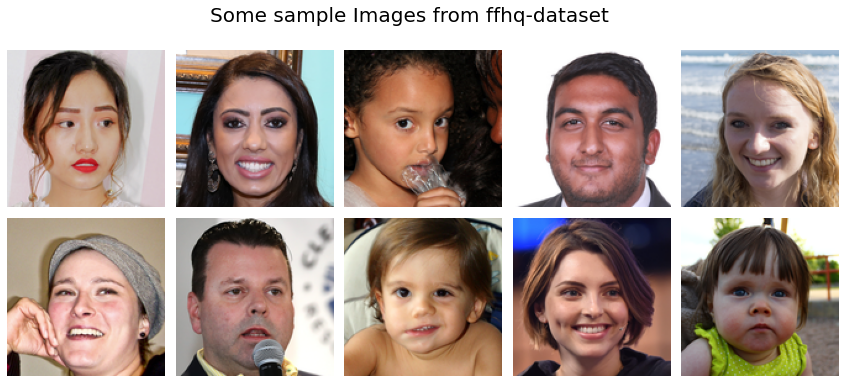

In [ ]:
# a batch of 512 images returned by data generator
sample_images = next(data_flow)[0] 

# only taking 10 of those to display
sample_images = sample_images[:10]

# displaying the images
display_image_grid(sample_images, 2, 5, "Some sample Images from ffhq-dataset")

## AUTOENCODER

#### Encoder

Below you will create the model for your encoder just like the one in Image Completion task (but not necessarily that same). The architecture of the Encoder consists of a stack of convolutional layers followed by a dense (fully connected) layer which outputs a vector of size <i>Z_DIM</i>. The whole image of size 128x128x3 is decoed into this latent space vector of size <i>Z_DIM</i>.


NOTE: You can experiment with the number of feature maps, kernel size, strides and number of conv layer.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 16)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 8)         1160      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16, 16, 8)         0     

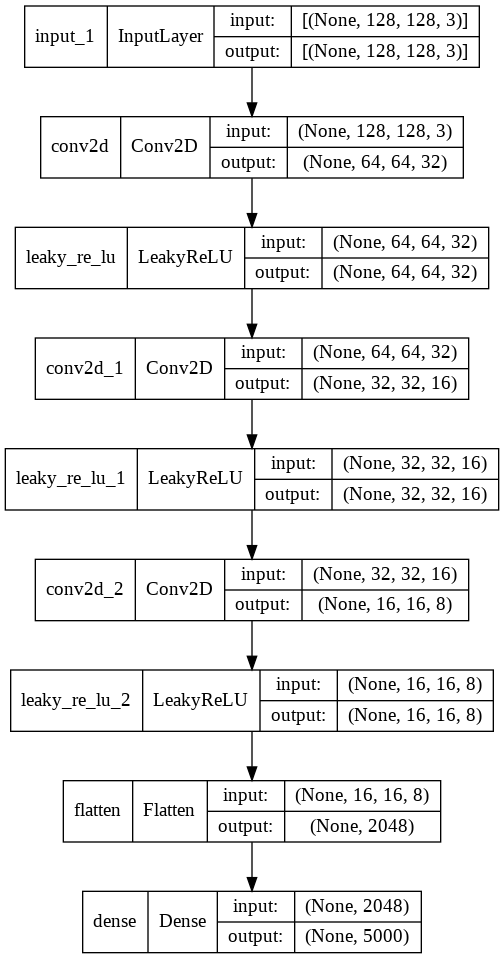

In [ ]:
ae_encoder = None
ae_encoder_output = None
ae_encoder_input = None


######################## WRITE YOUR CODE BELOW ########################
num_filters=[32,16,8]
kernel_size=[3,3,3]
strides=[2,2,2]
num_conv=len(num_filters)

ae_encoder_input=Input(shape=INPUT_DIM)


# ae_encoder=keras.Sequential()
# ae_encoder.add(ae_encoder_input)
for i in range(num_conv+1):
  if i==0:
    x=Conv2D(filters=num_filters[i],kernel_size=(kernel_size[i],kernel_size[i]), strides = (strides[i],strides[i]), padding = 'same')(ae_encoder_input)
    x=LeakyReLU()(x) 
    continue
  if i==num_conv:
    x=Flatten()(x)
    ae_encoder_output=Dense(units=Z_DIM)(x)
    break
  x=Conv2D(filters=num_filters[i],kernel_size=(kernel_size[i],kernel_size[i]), strides = (strides[i],strides[i]), padding = 'same')(x)
  x=LeakyReLU()(x)

ae_encoder=keras.Model(ae_encoder_input,ae_encoder_output)

########################### END OF YOUR CODE ##########################

ae_encoder.summary()
tf.keras.utils.plot_model(ae_encoder, show_shapes=True)


#### Decoder

Just like the encoder you will create the model for the decoder. This model can be the exact mirror of encoder model, but that is not mandatory.

Since the function of the Decoder to reconstruct the image from the latent vector. Therefore, it is necessary to define the decoder so as to increase the size of the activations gradually through the network. This can be achieved through the  [Conv2DTransponse](https://keras.io/layers/convolutional/#conv2dtranspose) layer. This layer produces an output tensor double the size of the input tensor in both height and width.

Again, you can experiment with the number of feature maps, kernel size, strides and number of conv layer.


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5000)]            0         
                                                                 
 dense_1 (Dense)             (None, 2048)              10242048  
                                                                 
 reshape (Reshape)           (None, 16, 16, 8)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 16)       1168      
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 16)        0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 64, 64, 32)       4640      
 ranspose)                                                 

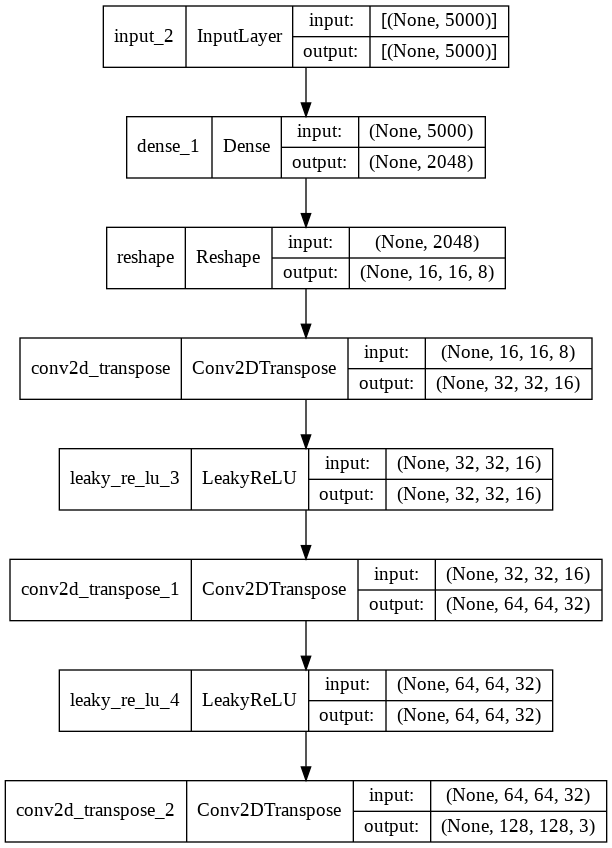

In [ ]:
ae_decoder = None
ae_decoder_output = None

######################## WRITE YOUR CODE BELOW ########################
num_filters=num_filters[0:len(num_filters)-1]
num_filters.insert(0,3)

inputs=list(reversed([layer.input for layer in ae_encoder.layers if str(type(layer))=="<class 'keras.layers.convolutional.Conv2D'>"]))
outputs = [layer.output for layer in ae_encoder.layers]
layers=list(reversed([layer for layer in ae_encoder.layers if str(type(layer))=="<class 'keras.layers.convolutional.Conv2D'>"]))
units=int(list(outputs[-2].shape)[1])

num_conv=len(num_filters)
num_filters=list(reversed(num_filters))
kernel_size=list(reversed(kernel_size))

ae_decoder_input=Input(Z_DIM)


# ae_decoder=keras.Sequential()
# ae_decoder.add(ae_decoder_input)
x=Dense(units=units)(ae_decoder_input)
x=tf.keras.layers.Reshape(tuple(outputs[-3].shape)[1:])(x)

outputs = list(reversed([layer.output for layer in ae_encoder.layers if str(type(layer))=="<class 'keras.layers.convolutional.Conv2D'>"]))
for i in range(num_conv):
  if i==num_conv-1:
    output_h=int(list(outputs[i].shape)[1])
    input_h=int(list(inputs[i].shape)[1])

    output_w=int(list(outputs[i].shape)[2])
    input_w=int(list(inputs[i].shape)[2])
    ae_decoder_output=Conv2DTranspose(filters=3,kernel_size=(kernel_size[-1],kernel_size[-1]), strides = (int(input_h/output_h),int(input_w/output_w)), padding = 'same',activation='sigmoid')(x)
    break
  output_h=int(list(outputs[i].shape)[1])
  input_h=int(list(inputs[i].shape)[1])

  output_w=int(list(outputs[i].shape)[2])
  input_w=int(list(inputs[i].shape)[2])
  x=Conv2DTranspose(filters=num_filters[i],kernel_size=(kernel_size[i],kernel_size[i]), strides = (int(input_h/output_h),int(input_w/output_w)) ,padding = 'same')(x)
  x=LeakyReLU()(x)
ae_decoder=keras.Model(ae_decoder_input,ae_decoder_output)
########################### END OF YOUR CODE ##########################

ae_decoder.summary()
tf.keras.utils.plot_model(ae_decoder, show_shapes=True)


#### Attaching the Decoder to the Encoder

Finally, here we connect the encoder to the docoder.

In [ ]:
autoencoder_model = None

######################## WRITE YOUR CODE BELOW ########################

# The input of the autoencoder will be the same as of encoder


# The output of the autoencoder will be the output of decoder, when passed encoder input


# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.

autoencoder_output = ae_decoder(ae_encoder(ae_encoder_input))
autoencoder_model=Model(inputs=ae_encoder_input,outputs=autoencoder_output)
########################### END OF YOUR CODE ##########################

autoencoder_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 model (Functional)          (None, 5000)              10251680  
                                                                 
 model_1 (Functional)        (None, 128, 128, 3)       10248723  
                                                                 
Total params: 20,500,403
Trainable params: 20,500,403
Non-trainable params: 0
_________________________________________________________________


### Training the AE

The hyperparameters are the same as given in the Image Completion task.

Also for training, you can use <i>Adam</i> optimizer with the learning rate given below (or you can try out your own).

The number of epochs given are 10, but experiment with that number to know where you can acheive the best results.

In [ ]:
LEARNING_RATE = 0.001
N_EPOCHS = 5

# compile your model here
optimizer=Adam(learning_rate=LEARNING_RATE)
autoencoder_model.compile(optimizer=optimizer,loss='mean_squared_error')
########################### END OF YOUR CODE ##########################

Now simply call the <i>fit</i> function of the model with the appropriate paramters.

In [ ]:
######################## WRITE YOUR CODE BELOW ########################
hist=autoencoder_model.fit(x=data_flow,epochs=N_EPOCHS,steps_per_epoch=int(len(filenames)/BATCH_SIZE))

########################### END OF YOUR CODE ##########################

Epoch 1/5
1093/1093 [==============================] - 162s 133ms/step - batch: 546.0000 - size: 63.9854 - loss: 0.0125
Epoch 2/5
1093/1093 [==============================] - 118s 108ms/step - batch: 546.0000 - size: 63.9854 - loss: 0.0056
Epoch 3/5
1093/1093 [==============================] - 110s 101ms/step - batch: 546.0000 - size: 63.9854 - loss: 0.0048
Epoch 4/5
1093/1093 [==============================] - 110s 100ms/step - batch: 546.0000 - size: 63.9854 - loss: 0.0043
Epoch 5/5
1093/1093 [==============================] - 109s 100ms/step - batch: 546.0000 - size: 63.9854 - loss: 0.0040


### Reconstruction

Now we will get a batch of images from ImageDataGenerator object and try to reconstruct the images after passing it through our autoencoder.

The first image grid shows the original images and the second grid shows the reconstructed images after passing it through the AE.

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


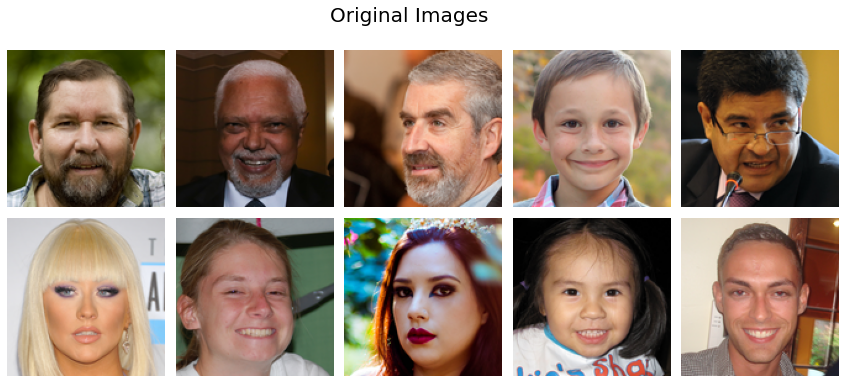

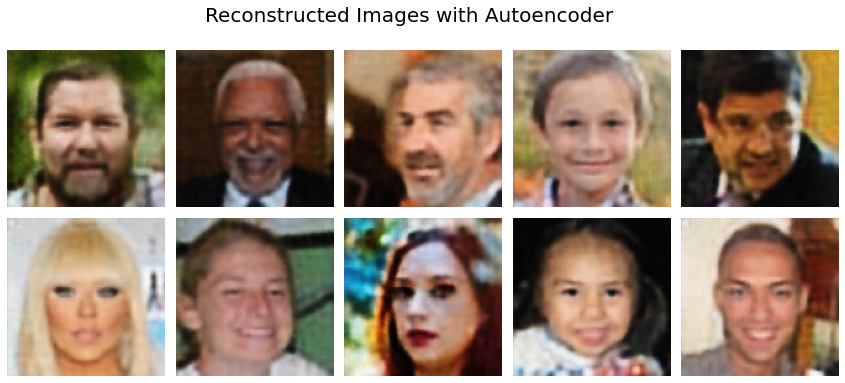

In [ ]:
test_batch = next(data_flow)[0]
test_images = test_batch[:10]

reconst_images = autoencoder_model.predict(test_images)

display_image_grid(test_images, 2, 5, "Original Images")
display_image_grid(reconst_images, 2, 5, "Reconstructed Images with Autoencoder")

<i>NOTE:</i> The reason that you are seeing the reconstructed images as blurry because MSE averages out the differences between individual pixel values. GANs (which you will see in the next assignment) on the other hand produces much sharper results. 

Adding noise before decoding the images

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


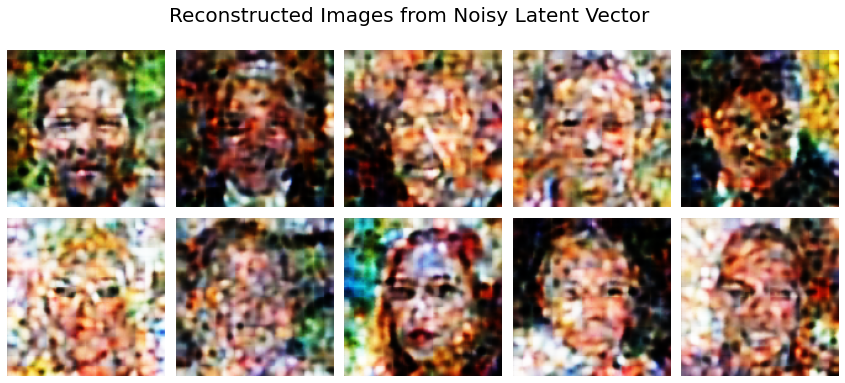

In [ ]:
num_of_images = 10

# encoding our images
encodings = ae_encoder.predict(test_images)

# adding random normal noise to the encoded latent vectors
encodings += np.random.normal(0.0, 1.0, size = (num_of_images, Z_DIM))

# reconstruct from noisy latent vector
reconst_images_noisy = ae_decoder.predict(encodings)

display_image_grid(reconst_images_noisy, 2, 5, "Reconstructed Images from Noisy Latent Vector")

It can be observed that the images are starting to get distorted with a bit of noise added to its encodings. One possible reason could be that the model did not ensure that the space around the encoded values (latent space) was continuous. We will see later how to overcome this with the help of Variational Autoencoder.

### Generation 
Generate images from latent vectors sampled from a standard normal distribution

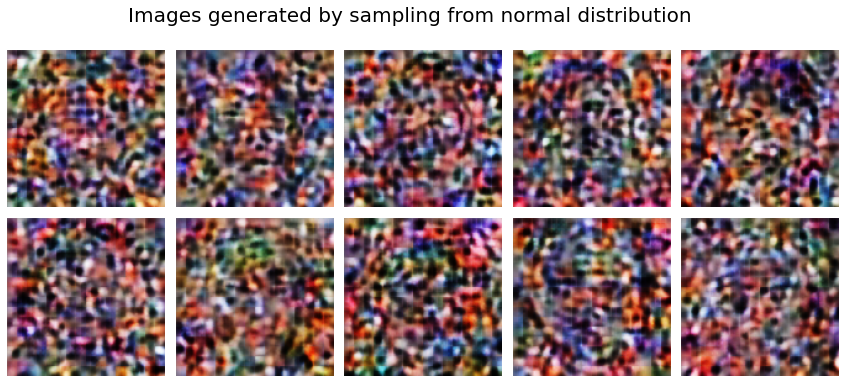

In [ ]:
reconst_images = ae_decoder.predict(np.random.normal(0,1,size=(num_of_images, Z_DIM)))

display_image_grid(reconst_images, 2, 5, "Images generated by sampling from normal distribution")

It is evident that the latent vector sampled from a standard normal distribution can not be used to generate new faces. This shows that the latent vectors generated by the model are not centered/symmetrical around the origin. This also strengthens our inference that the latent space is not continuous.

Since we do not have a definite distribution to sample latent vectors from, it is unclear as to how we can generate new faces. We observed that adding a bit of noise to the latent vector does not produce new faces. We can encode and decode images but that does not meet our objective of learning the joing distribution of data. 

Building on this thought, wouldn't it be great if we could generate new faces from latent vectors sampled from a standard normal distribution? This is essentially what a Variational Autoencoder does.

## VARIATIONAL AUTOENCODER



Variational Autencoders tackle most of the problems discussed above. They are trained to generate new faces from latent vectors sampled from a standard normal distribution. While a Simple Autoencoder learns to map each image to a fixed point in the latent space, the Encoder of a Variational Autoencoder (VAE) maps each image to a z-dimensional standard normal distribution. 



Here is a high level overview of what a Variational Autoencoder does.

<br>
<img src="https://blog.bayeslabs.co/assets/img/vae.jpg"> 
<br><i>Source : blog.bayeslabs.co/2019/06/04/All-you-need-to-know-about-Vae</i>

#### Encoder

The encoder for the Variational AE is little trickier than the simple autoencoder.  While a Simple Autoencoder learns to map each image to a fixed point in the latent space, the Encoder of a Variational Autoencoder (VAE) maps each image to a z-dimensional standard normal distribution. It will loos something like this:

<center>

![picture](https://drive.google.com/uc?export=view&id=1e3iGHK0s83O-RjpbRkO4OWKU52B5kS2I)

</center>

You will need Keras' functional API to make this type of model as this is not a simple feed forward network. You can read and learn more about Function API [here](https://keras.io/guides/functional_api/).

The input to the Decoder, as shown in the image above is a vector sampled from the normal distribution represented by the output of the Encoder - $\mu$ and $\sigma$. This sampling can be done as follows:

<center>
$Z = \mu + \sigma\varepsilon$
</center>

where $\varepsilon$ is a sampled from a multivariate standard normal distribution.


In [ ]:
mean_mu = None
var = None
vae_encoder_input = None
vae_encoder = None
vae_encoder_output = None

######################## WRITE YOUR CODE BELOW ########################

# define your convolution layers here
vae_encoder_input=Input(shape=INPUT_DIM)

num_filters=[32,64,64,64]
kernel_size=[3,3,3,3,3]
strides=[2,2,2,2]
num_conv=len(num_filters)

vae_encoder_input=Input(shape=INPUT_DIM)

for i in range(num_conv+1):
  if i==0:
    x=Conv2D(filters=num_filters[i],kernel_size=(kernel_size[i],kernel_size[i]), strides = (strides[i],strides[i]), padding = 'same')(vae_encoder_input)
    x = BatchNormalization()(x)
    x=LeakyReLU()(x) 
    continue
  if i==num_conv:
    x=Flatten()(x)
    break
  x=Conv2D(filters=num_filters[i],kernel_size=(kernel_size[i],kernel_size[i]), strides = (strides[i],strides[i]), padding = 'same')(x)
  x = BatchNormalization()(x)
  x=LeakyReLU()(x)

# define mean and var dense layers outputed by your model
mean_mu=Dense(units=Z_DIM)(x)
var=Dense(units=Z_DIM)(x)

########################### END OF YOUR CODE ##########################

# here is your model outputing mu and var seperately
# now we will take samples from these paramters of distributions
# and these samples will be our latent vector, which 
# can be feed to our decoder


# Defining a function for sampling
# this function takes mean and var vectors and 
def sample_from_distribution(args):
  mean_mu, var = args
  epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
  return mean_mu + K.exp(var/2)*epsilon   
  
# Using a Keras Lambda Layer to include the sampling function as a layer in the model
vae_encoder_output = Lambda(sample_from_distribution, name='encoder_output')([mean_mu, var])

vae_encoder = Model(vae_encoder_input, vae_encoder_output)
vae_encoder.summary()
# tf.keras.utils.plot_model(vae_encoder, "vae_encoder.png", show_shapes=True)

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 64, 64, 32)   896         ['input_16[0][0]']               
                                                                                                  
 batch_normalization_28 (BatchN  (None, 64, 64, 32)  128         ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                                           

#### Decoder
Since the Decoder remains the same, you can use the same architecture of the decoder of Autoencoder.

In [ ]:
vae_decoder = None
vae_decoder_output = None

######################## WRITE YOUR CODE BELOW ########################
num_filters=num_filters[0:len(num_filters)-1]
num_filters.insert(0,3)

inputs=list(reversed([layer.input for layer in vae_encoder.layers if str(type(layer))=="<class 'keras.layers.convolutional.Conv2D'>"]))
outputs = [layer.output for layer in vae_encoder.layers]
layers=list(reversed([layer for layer in vae_encoder.layers if str(type(layer))=="<class 'keras.layers.convolutional.Conv2D'>"]))
units=int(list(outputs[-4].shape)[1])

num_conv=len(num_filters)
num_filters=list(reversed(num_filters))
kernel_size=list(reversed(kernel_size))

vae_decoder_input=Input(Z_DIM)

# ae_decoder=keras.Sequential()
# ae_decoder.add(ae_decoder_input)
x=Dense(units=units)(vae_decoder_input)
x=tf.keras.layers.Reshape(tuple(outputs[-5].shape)[1:])(x)


outputs = list(reversed([layer.output for layer in vae_encoder.layers if str(type(layer))=="<class 'keras.layers.convolutional.Conv2D'>"]))
for i in range(num_conv):
  if i==num_conv-1:
    output_h=int(list(outputs[i].shape)[1])
    input_h=int(list(inputs[i].shape)[1])

    output_w=int(list(outputs[i].shape)[2])
    input_w=int(list(inputs[i].shape)[2])
    vae_decoder_output=Conv2DTranspose(filters=3,kernel_size=(kernel_size[-1],kernel_size[-1]), strides = (int(input_h/output_h),int(input_w/output_w)), padding = 'same',activation='sigmoid')(x)
    break
  output_h=int(list(outputs[i].shape)[1])
  input_h=int(list(inputs[i].shape)[1])

  output_w=int(list(outputs[i].shape)[2])
  input_w=int(list(inputs[i].shape)[2])
  x=Conv2DTranspose(filters=num_filters[i],kernel_size=(kernel_size[i],kernel_size[i]), strides = (int(input_h/output_h),int(input_w/output_w)) ,padding = 'same')(x)
  x = BatchNormalization()(x)
  x=LeakyReLU()(x)
vae_decoder=keras.Model(vae_decoder_input,vae_decoder_output)
########################### END OF YOUR CODE ##########################

vae_decoder.summary()
# tf.keras.utils.plot_model(vae_decoder, show_shapes=True)


Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 5000)]            0         
                                                                 
 dense_16 (Dense)            (None, 4096)              20484096  
                                                                 
 reshape_5 (Reshape)         (None, 8, 8, 64)          0         
                                                                 
 conv2d_transpose_19 (Conv2D  (None, 16, 16, 64)       36928     
 Transpose)                                                      
                                                                 
 batch_normalization_32 (Bat  (None, 16, 16, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_37 (LeakyReLU)  (None, 16, 16, 64)        0  

#### Attaching the Decoder to the Encoder

Just like in the case of autoencoder, you will connect your encoder with docer and make the final model.


In [ ]:
######################## WRITE YOUR CODE BELOW ########################


# The input to the model will be the image fed to the encoder.


# Output will be the output of the decoder. The term - decoder(encoder_output) 
# combines the model by passing the encoder output to the input of the decoder.


# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
vae_output = vae_decoder(vae_encoder(vae_encoder_input))
vae_model=Model(inputs=vae_encoder_input,outputs=vae_output)
########################### END OF YOUR CODE ##########################

vae_model.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 model_15 (Functional)       (None, 5000)              41064144  
                                                                 
 model_16 (Functional)       (None, 128, 128, 3)       20577923  
                                                                 
Total params: 61,642,067
Trainable params: 61,641,299
Non-trainable params: 768
_________________________________________________________________


### Loss Function

The loss function is a sum of MSE and KL Divergence. MSE error contorls the quality of images (as already seen in the simple autoencoder) while including the KL divergence loss in addition to the MSE loss, the VAE is forced to ensure that the encodings are very similar to a multivariate standard normal distribution. Since a multivariate standard normal distribution has a zero mean, it is centered around the origin. Mapping each image to a standard normal distribution as opposed to a fixed point ensures that the latent space is continuous and the latent vectors are centered around the origin. Here is equation of KL loss, where <b>$\mu$</b> and <b>$\sigma$</b> are the vectors returned by encoder.

<br>
<center>
$D_{KL}[N(\mu,\sigma) \ || \ N(0,1)] = \frac{1}{2}\sum_{i=1}^{z}(1+\log(\sigma_i^2) - \mu_i^2 - \sigma_i^2)$
</center>
</br>

A weight (loss factor) is assigned to the MSE loss. This penalizes the model by loss factor more than KL Diverge to ensure that images produced are of good quality. If we make this loss factor small, the images will be not of good quality. If we make this loss factor large, then our model will simply act as a simple AE.

Hence, this (loss_factor) is also a hyperparamter that you need to take care of. 

Here is the [link](https://keras.io/api/losses/) to Keras documentation on how to create custom loss functions. 

In [ ]:
def total_loss(y_true, y_pred):

    mean_vector = mean_mu   # mean vector outputed by encoder
    var_vector = var        # var vector outputed by encoder
    mse_loss = 0
    kl_loss = 0


    ######################## WRITE YOUR CODE BELOW ########################
    # calculate mse loss here
    mse_loss=tf.reduce_mean(tf.math.square(y_true-y_pred),axis=3)
    mse_loss=tf.reduce_mean(mse_loss,axis=2)
    mse_loss=tf.reduce_mean(mse_loss,axis=1)
    # calculate kl loss here
    kl_loss=tf.reduce_sum(1+var_vector-tf.math.square(mean_vector)-tf.math.exp(var_vector),axis=1)*(-0.5)
    ########################### END OF YOUR CODE ##########################
    return tf.reduce_mean(LOSS_FACTOR * mse_loss + kl_loss)


The loss function is a sum of RMSE and KL Divergence. A weight is assigned to the RMSE loss, known as the loss factor. The loss factor is multiplied with the RMSE loss. If we use a high loss factor, the drawbacks of a Simple Autoencoder start to appear. However, if we use a loss factor too low, the quality of the reconstructed images will be poor. Hence the loss factor is a hyperparameter that needs to be tuned.

In [ ]:
LEARNING_RATE= 0.001
N_EPOCHS = 10
LOSS_FACTOR = 8000

### Training the VAE


Compile your model below.

In [ ]:
######################## WRITE YOUR CODE BELOW ########################
optimizer=Adam(learning_rate=LEARNING_RATE)
vae_model.compile(optimizer=optimizer,loss=total_loss)
########################### END OF YOUR CODE ##########################

Now call fit function on your model with appropriate paramters.

In [ ]:
######################## WRITE YOUR CODE BELOW ########################
hist=vae_model.fit(x=data_flow,epochs=N_EPOCHS,steps_per_epoch=int(len(filenames)/BATCH_SIZE))
########################### END OF YOUR CODE ##########################

Epoch 1/10
546/546 [==============================] - 180s 315ms/step - batch: 272.5000 - size: 127.9707 - loss: 382.0680
Epoch 2/10
546/546 [==============================] - 172s 315ms/step - batch: 272.5000 - size: 127.9707 - loss: 284.5381
Epoch 3/10
546/546 [==============================] - 172s 316ms/step - batch: 272.5000 - size: 127.9707 - loss: 266.9453
Epoch 4/10
546/546 [==============================] - 171s 314ms/step - batch: 272.5000 - size: 127.9707 - loss: 255.6632
Epoch 5/10
546/546 [==============================] - 170s 312ms/step - batch: 272.5000 - size: 127.9707 - loss: 244.7975
Epoch 6/10
546/546 [==============================] - 170s 312ms/step - batch: 272.5000 - size: 127.9707 - loss: 236.9431
Epoch 7/10
546/546 [==============================] - 171s 312ms/step - batch: 272.5000 - size: 127.9707 - loss: 228.9642
Epoch 8/10
546/546 [==============================] - 171s 313ms/step - batch: 272.5000 - size: 127.9707 - loss: 220.4559
Epoch 9/10
546/546 [====

### Reconstruction
The reconstruction process is the same as that of the Simple Autoencoder.

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


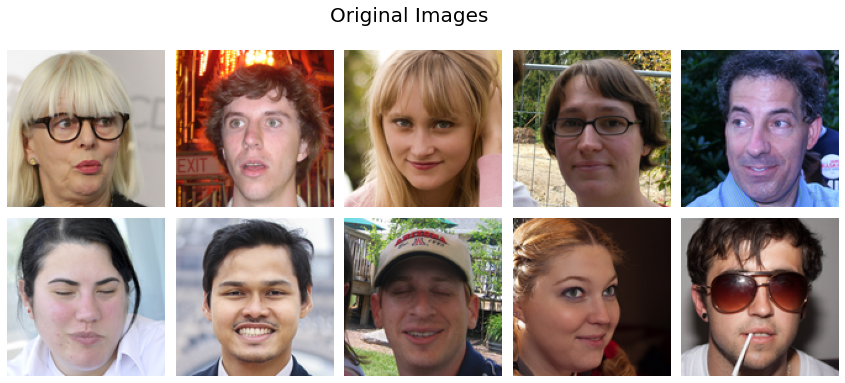

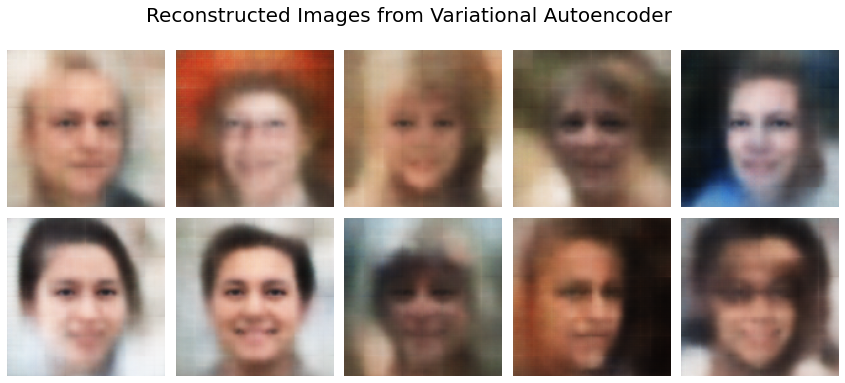

In [ ]:
test_batch = next(data_flow)[0]
test_images = test_batch[:10]

reconst_images = vae_model.predict(test_images)

display_image_grid(test_images, 2, 5, "Original Images")

display_image_grid(reconst_images, 2, 5, "Reconstructed Images from Variational Autoencoder")

###Generation
Generating new faces from random vectors sampled from a standard normal distribution. 

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


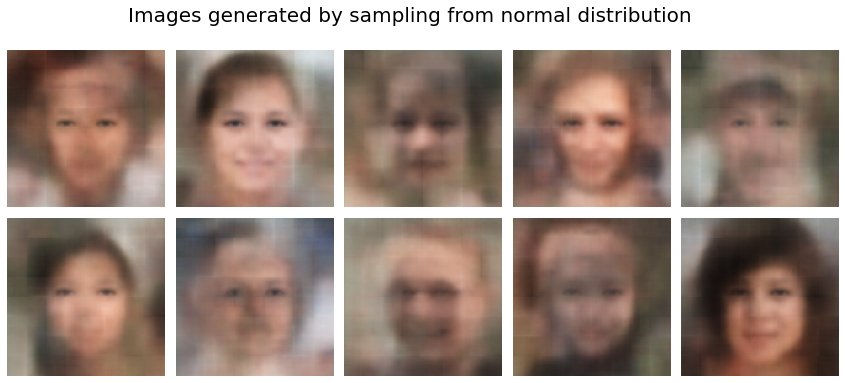

In [ ]:
reconst_images = vae_decoder.predict(np.random.normal(0,1,size=(10, Z_DIM)))

display_image_grid(reconst_images, 2, 5, "Images generated by sampling from normal distribution")

The VAE is evidently capable enough of producing new faces from vectors samped from a standard normal distribution. The fact that a neural network is capable of generating new faces from random noise shows how powerful it is in performing extremely complex mappings!

## REPORT

Report your results for different values of <b>Z_DIM</b>, <b>learning rate</b>, <b>optimizers</b>, <b> encoder and decoder model and Loss Factor</b> and tell us for which configuration you acheived the best results (The best run model should be the last run model in this notebook, showing the results in the cell above).

Answer: